In [165]:
from urllib.parse import urlparse, parse_qs
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import JSONFormatter, TextFormatter
import json
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
from langchain_ollama.llms import OllamaLLM
import unittest
import importlib.util
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
import re
import pytest
import subprocess
import requests
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_groq import ChatGroq
from langchain_core.tools import Tool
from langchain_core.runnables import RunnableBinding
from rich.console import Console
from rich.markdown import Markdown
from yt_dlp import YoutubeDL
from collections import Counter

console = Console()
load_dotenv()

True

### Transcript Tool

In [166]:
def get_video_id(url:str) -> str:
    """
    Process the url and fetches the video Id.
    Args:
        url: url of the YouTube video
    """
    # Parse URL
    parsed_url = urlparse(url)

    # Extract query parameters as a dictionary
    query_params = parse_qs(parsed_url.query)
    video_id = query_params['v']
    return ''.join(video_id)

def get_transcript(url:str) -> str:
    """
    Generates the Transcript for the provided url

    Args:
        url: url of the YouTube video
    """
    video_id = get_video_id(url)
    transcripts = YouTubeTranscriptApi.get_transcript(video_id=video_id, languages=['en'],preserve_formatting=True)
    formatter = JSONFormatter()

    # .format_transcript(transcript) turns the transcript into a JSON string.
    json_formatted = json.loads(formatter.format_transcript(transcripts))

    transcript_text = " ".join([entry["text"] for entry in json_formatted])

    return transcript_text


# Function to get video description
def get_youtube_description(video_url):
    ydl_opts = {
        'quiet': True,
        'skip_download': True,
        'force_generic_extractor': True,
        'extract_flat': True,
        'dumpjson': True
    }
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        return info.get('description', 'No description available')
    
def get_github_link(content:str) -> str | None:
    """
    Fetches git hub link from the given video url description
    """
    github_url_pattern = r"https?://(?:www\.)?github\.com/[A-Za-z0-9_.-]+/[A-Za-z0-9_.-]+(?:/tree/[A-Za-z0-9_.-]+|/blob/[A-Za-z0-9_.-]+)?(?:/[A-Za-z0-9_/.-]*)?"
    link = re.findall(github_url_pattern, content)
    if link:
        return link[0]
    else:
        return

# Function to recursively get all code files from a GitHub repo
def list_repo_files_recursive(repo_url, path=""):
    api_url = repo_url.replace("github.com", "api.github.com/repos") + f"/contents/{path}"
    headers = {"Accept": "application/vnd.github.v3+json"}
    
    response = requests.get(api_url, headers=headers)
    if response.status_code != 200:
        return []

    files = []
    for item in response.json():
        if item["type"] == "file" and item["name"].endswith(('.py', '.js', '.java', '.cpp', '.c', '.sh', '.rb')):
            files.append(item["download_url"])
        elif item["type"] == "dir":  # If it's a folder, recurse into it
            files.extend(list_repo_files_recursive(repo_url, item["path"]))

    return files

# Function to fetch code from each file
def fetch_code(files):
    code_snippets = {}
    for file_url in files:
        response = requests.get(file_url)
        if response.status_code == 200:
            code_snippets[file_url] = response.text[:1000]  # Limiting to first 1000 chars
    return code_snippets

def get_github_code(url:str) -> str|None:
    vid_des = get_youtube_description(url)
    if vid_des:
        git_link = get_github_link(vid_des)
        if git_link:
            files = list_repo_files_recursive(git_link)
            if files:
                code_snippets = fetch_code(files)
                return code_snippets
    return None

def extract_keywords(text, num_keywords=10):
    words = re.findall(r'\b[a-zA-Z]{4,}\b', text.lower())  # Extract words (ignore short ones)
    common_words = Counter(words).most_common(num_keywords)
    return [word for word, count in common_words]


# get_transcript('https://www.youtube.com/watch?v=smHnz2RHJBY')

# x = get_youtube_description('https://www.youtube.com/watch?v=Ih1LDnPijFU&t=2s')
# git_link = get_github_link(x)
# if git_link:
#     files = list_repo_files_recursive(git_link)




In [167]:
class State(TypedDict):
    input:str
    transcript: str
    feedback: str
    feedback_comments:str
    blog_content: str

In [168]:
# llm = OllamaLLM(model="deepseek-r1:1.5b")
llm = OllamaLLM(model="llama3.2:1b")


# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# llm = ChatGroq(model="llama3-8b-8192")

### Tools

In [169]:
tools=[get_transcript]
# llm_with_tools = llm.bind_tools(tools)

### Functions

### global Variables

In [170]:
git_hub_code = None
seo_checklist = None

In [171]:
def print_llm_response(response):
    """Pretty print LLM response as Markdown."""
    console.print(Markdown(response))  # Rich formats Markdown-like LLM output

def extract_urls(text):
    url_pattern = r"https?://[^\s]+"
    return re.findall(url_pattern, text)[0]

def generate_transcript(state:State):
    """
    Generates the transcript for the videolink provided.
    """
    global git_hub_code, seo_checklist
    url = extract_urls(state['input'])
    raw_text = get_transcript(url)
    # raw_text = clean_transcript(raw_text)
    seo_checklist = extract_keywords(raw_text)
    code_snippets = get_github_code(url)
    if code_snippets:
        code_str = "\n\n".join([f"### {url}\n```python\n{code}\n```" for url, code in code_snippets.items()])
        git_hub_code = code_str
    else:
        git_hub_code = None
    return {'transcript': raw_text}

# Function to clean transcript
def clean_transcript(raw_text):
    prompt = f"""
    The following text is a raw transcript from a YouTube video:
    
    {raw_text}

    1. Format it into well-structured paragraphs.
    2. Add punctuation for readability.
    3. Remove unnecessary filler words.
    4. Ensure proper sentence flow.
    
    Return only the cleaned text.
    """
    return llm.invoke(prompt)  # LLM fixes structure

# Function to generate a blog title
def generate_title(cleaned_text):
    global seo_checklist
    if seo_checklist:
        prompt = f"""Create an engaging and SEO-friendly title {seo_checklist}."""
    else:
        prompt = f"Generate one engaging blog title based on the following content:\n{cleaned_text}"
    return llm.invoke(prompt)

def generate_blog_content(state:State):
    global git_hub_code, seo_checklist
    if not state.get('feedback_comments', None):
        prompt = f"""
                    You are an expert technical writer. Your task is to generate a well-structured and engaging blog post based on the given YouTube video transcript and SEO keywords.  

                    ### **Inputs:**  
                    - **Transcript:** {state['transcript']}  
                    - **SEO Keywords:** {seo_checklist}  
                    - **Number of words:** 2500

                    ### **Blog Requirements:**  
                    1. **Title:** {generate_title(state['transcript'])}.  
                    2. **Introduction:** Provide a compelling introduction summarizing the video topic.  
                    3. **Main Sections:**  
                    - Organize content into meaningful sections based on key points from the transcript.  
                    - Use **subheadings (H2, H3)** for clear structure.  
                    - Integrate **SEO keywords naturally** into the content.  
                    4. **Conclusion:** Summarize key takeaways and provide a call to action.  

                    Ensure the blog is **clear, well-formatted, and optimized for readability.** Return only the final blog post without additional explanations.  
                """
        if git_hub_code:
            prompt += f"""
                    - **Striclty integrate Code snippets** from {git_hub_code} where relevant.
                    - Provide a **hands-on tutorial** with code snippets (if needed).  
                    - Explain each step clearly, ensuring the reader can follow along.  
                    - Use markdown formatting for **code blocks** (Python, Bash, SQL, etc.)."""
                
    else:
        prompt = state['feedback_comments']

    res = llm.invoke(prompt)
    return {'blog_content': res}

def review_blog_content(state:State):
    ## get user input
    print_llm_response(state['blog_content'])
    
    user_input=input("Please choose one of the option and press enter: A - Approve, C - Comments")
    decision = {'A': 'accepted', 'C': 'review_comments', 'a':'accepted', 'c':'review_comments'}
    return {'feedback': decision[user_input]}

def revise_blog_content(state:State):
    """ Add review comments by Expert to the given topic and re-write the Blog"""

    review_comments = input(f"what would you like to add more?")

    print("### Updating again with user comments ####")
    print(review_comments)
    print("####################")

    prompt = f"""Here is the original blog post:  
                    {state['blog_content']}  

                    Transcript: {state['transcript']}

                    User Feedback:  
                    {review_comments}

                    Based on this feedback, improve the blog by:  
                    1. Enhancing clarity and readability.  
                    2. Reorganizing content if necessary.  
                    3. Incorporating missing details or additional insights.  
                    4. Refining tone to better suit the audience.  
                    5. **Do not** add explanations, reasoning.  

                    Return the **revised blog post** while maintaining a natural flow.  
                    Ensure that all suggestions are addressed while keeping the article engaging and informative.
                    """

    return {'feedback_comments':prompt}


### Workflow

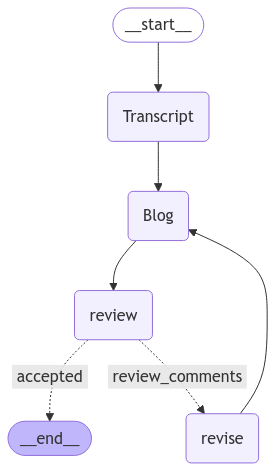

In [172]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("Transcript", generate_transcript)
# workflow.add_node("Blog_plan", generate_plan_for_blog_content)
workflow.add_node("Blog", generate_blog_content)
workflow.add_node("review", review_blog_content)
workflow.add_node("revise", revise_blog_content)

# Add Edges
workflow.add_edge(START, "Transcript")
workflow.add_edge("Transcript", "Blog")
# workflow.add_edge("Blog_plan", "Blog")
workflow.add_edge("Blog", "review")
workflow.add_conditional_edges(
    "review",
    lambda state: state["feedback"],
    {  # Name returned by route_decision : Name of next node to visit
        "accepted": END,
        "review_comments": "revise",
    },
)
workflow.add_edge('revise', 'Blog')

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

TOOL CALLS ARE WORKING ONLY WITH "MESSAGE STATE". NOT ABLE TO MAKE A HYBRID HYBRID GRAPH NODES THAT ACCEPTS BOTH DICT TYPE AND MESSAGESTATE TYPE.

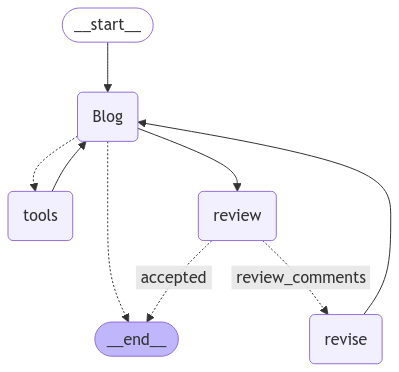

In [173]:
builder = StateGraph(State)

# Add nodes

builder.add_node("tools",ToolNode(tools))
# workflow.add_node("Blog_plan", generate_plan_for_blog_content)
builder.add_node("Blog", generate_blog_content)
builder.add_node("review", review_blog_content)
builder.add_node("revise", revise_blog_content)

# Add Edges
builder.add_edge(START, "Blog")
builder.add_conditional_edges(
    "Blog",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "Blog")
builder.add_edge("Blog", "review")
builder.add_conditional_edges(
    "review",
    lambda state: state["feedback"],
    {  # Name returned by route_decision : Name of next node to visit
        "accepted": END,
        "review_comments": "revise",
    },
)
builder.add_edge('revise', 'Blog')

# Compile
chain1 = builder.compile()

# Show workflow
display(Image(chain1.get_graph().draw_mermaid_png()))

In [174]:
# Invoke
# state = chain1.invoke({"input": "https://www.youtube.com/watch?v=smHnz2RHJBY"})
# print(state["blog_content"])

MOVING WITH WORKFLOW NOT BUILDER

In [175]:
# Invoke
state = chain.invoke({"input": "https://www.youtube.com/watch?v=mJwPvyc4-rk"})
print_llm_response(state["blog_content"])

Here's the rewritten blog based on the provided transcript:                                                        

Title: Super Base: The Ultimate Game-Changing Platform for Developers                                              

Introduction: In this video, Greg from Ras Mike shows us how Super Base can revolutionize the way we build our     
personal projects and businesses. With a comprehensive platform that combines user management, authentication, and 
database integration, developers can create seamless experiences for their users.                                  

Main Sections:                                                                                                     

                                                Authentication Flow                                                

Greg begins by explaining the authentication flow in Super Base, highlighting its simplicity and efficiency. He    
showcases how users sign up, log in, and receive personalized recommendations based on their behavior.             

 • We start with a "Before" image, showing the traditional approach to authentication.                             
 • Then, we transition into the "Now" section, demonstrating the streamlined process of signing up, logging in, and
   receiving recommendations.                                                                                      
 • Next, we explore how Super Base's "After" image showcases the seamless experience users have with their         
   accounts.                                                                                                       

                                               Database Integration                                                

Greg delves deeper into database integration, highlighting the benefits of using Super Base for managing user data.
He explains how the platform connects to your database, allowing you to store and manage user information in one   
place.                                                                                                             

 • We see a "Before" image showing traditional database management methods.                                        
 • Then, we move on to the "Now" section, demonstrating how Super Base's integration with your database makes it   
   easy to store and retrieve user data.                                                                           

                                                  Payment Gateway                                                  

Greg also showcases Super Base's payment gateway capabilities, enabling you to accept payments from users. He      
explains how the platform integrates with popular payment gateways, making it simple to process transactions       
securely.                                                                                                          

 • We see a "Before" image showing traditional payment processing methods.                                         
 • Then, we transition into the "Now" section, highlighting Super Base's secure and user-friendly payment          
   experience.                                                                                                     

                                                    Deployment                                                     

Greg concludes by discussing deployment options for Super Base, making it easy to share your application with the  
world. He shows how users can deploy their projects directly from the platform.                                    

 • We see a "Before" image showing traditional deployment methods.                                                 
 • Then, we move on to the "Now" section, demonstrating how Super Base's deployment options make it simple to      
   publish your project.                                                                                           

                                        

Here's the rewritten blog based on the provided transcript:                                                        

Title: Super Base: The Ultimate Game-Changing Platform for Developers                                              

Introduction: In this video, Greg from Ras Mike shows us how Super Base can revolutionize the way we build our     
personal projects and businesses. With a comprehensive platform that combines user management, authentication, and 
database integration, developers can create seamless experiences for their users.                                  

Main Sections:                                                                                                     

                                                Authentication Flow                                                

Greg begins by explaining the authentication flow in Super Base, highlighting its simplicity and efficiency. He    
showcases how users sign up, log in, and receive personalized recommendations based on their behavior.             

 • We start with a "Before" image, showing the traditional approach to authentication.                             
 • Then, we transition into the "Now" section, demonstrating the streamlined process of signing up, logging in, and
   receiving recommendations.                                                                                      
 • Next, we explore how Super Base's "After" image showcases the seamless experience users have with their         
   accounts.                                                                                                       

                                               Database Integration                                                

Greg delves deeper into database integration, highlighting the benefits of using Super Base for managing user data.
He explains how the platform connects to your database, allowing you to store and manage user information in one   
place.                                                                                                             

 • We see a "Before" image showing traditional database management methods.                                        
 • Then, we move on to the "Now" section, demonstrating how Super Base's integration with your database makes it   
   easy to store and retrieve user data.                                                                           

                                                  Payment Gateway                                                  

Greg also showcases Super Base's payment gateway capabilities, enabling you to accept payments from users. He      
explains how the platform integrates with popular payment gateways, making it simple to process transactions       
securely.                                                                                                          

 • We see a "Before" image showing traditional payment processing methods.                                         
 • Then, we transition into the "Now" section, highlighting Super Base's secure and user-friendly payment          
   experience.                                                                                                     

                                                    Deployment                                                     

Greg concludes by discussing deployment options for Super Base, making it easy to share your application with the  
world. He shows how users can deploy their projects directly from the platform.                                    

 • We see a "Before" image showing traditional deployment methods.                                                 
 • Then, we move on to the "Now" section, demonstrating how Super Base's deployment options make it simple to      
   publish your project.                                                                                           

                                        

In [176]:
print(git_hub_code)

None


In [177]:
del git_hub_code

In [179]:
print_llm_response(clean_transcript(state['transcript']))

Here's the cleaned version of the given script:                                                                    

Greg: Hey everyone, I've been working on a new tutorial and I'd like to share it with you.                         

I recently completed a tutorial that covers the process of creating an application using Super Base. The main focus
was on authentication, database connections, and server deployments.                                               

One of the most exciting aspects of this tutorial is how easy it was to set up and deploy the application on my own
server.                                                                                                            

Finally, I wanted to highlight some key points about what people often miss when it comes to authentication:       
maintaining their API changes.                                                                                     

To recap, here are two action items:                                                                               

If you enjoyed this tutorial, please consider subscribing and liking Greg's channel. Additionally, Michael's       
YouTube channel is highly recommended for more tutorials like this.                                                

I appreciate all the feedback and comments I received during my last video. I'll try my best to respond to every   
comment moving forward.                                                                                            

Thank you, everyone, for showing love! It means a lot to me.                                                       

Greg: And that's the game! Thank you again Greg as always.